<a href="https://colab.research.google.com/github/JuanCruzFM/Procesamiento-Digital-de-Imagenes/blob/master/MultifractalBoxDimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> El objetivo del trabajo propuesto es determinar el espectro multifractal de imagenes satelitales de la Ria de Bahía Blanca para su caracterización. 







In [9]:
from math import log,floor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linsolve

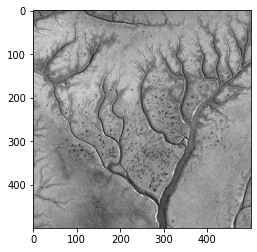

In [12]:
#importo la imagen y la convierto a un arreglo en escala gris
imagen='rec01.bmp'
Imagen=Image.open(imagen).convert('L')
ArregloImagen=np.array(Imagen).astype(int)
ancho,alto =ArregloImagen.shape
plt.imshow(ArregloImagen,cmap='gray')
plt.show()

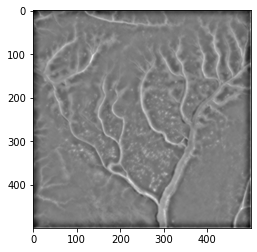

In [24]:
N=20 #cantidad de celdas utilizadas para calcular la medida en un punto (x,y),el lado de la celda es 2*n+1
#defino arreglos que voy a utilizar para obtener la alfa-imagen
medida=np.zeros(N*alto)
AlfaImagen=np.zeros((ancho,alto))
auxx=np.zeros(N) 
for i in range(N):
    auxx[i]=2*(i+1)+1
denominador=np.log(auxx)
b = np.vstack((denominador,np.ones((1,N)))).T
AA=coo_matrix(np.kron(np.identity(ancho), b))
#obtengo la alfa-imagen a traves de cuadrados minimos 
for x in range(ancho):
    for y in range(alto):
        for CantCeldas in range(N):
            
            medida[CantCeldas+y*N]=np.sum(ArregloImagen[max(x-(CantCeldas+1),0):min(x+(CantCeldas+2),ancho-1),max(y-(CantCeldas+1),0):min(y+(CantCeldas+2),alto-1)]) + 0.01

    bb=np.log(medida)
    z = linsolve.lsqr(AA,bb)[0]
    z = z.reshape(2,alto,order = 'F')
    AlfaImagen[x,:] = z[0] 
plt.imshow(AlfaImagen,'gray')
plt.show()  

In [14]:
#Maximo y minimo valor de alfa 
AlfaMax=np.amax(AlfaImagen)
AlfaMin=np.amin(AlfaImagen)
#Defino el número de clases de equivalencia
C=15 

Delta=(AlfaMax-AlfaMin)/C
#Vector de clases de equivalencias
VC=np.zeros(C)
VC = np.arange(AlfaMin,AlfaMax,Delta) 
#vector auxiliar para generar la alfa imagen
PC=np.zeros(C+1)
PC[0:C]=VC
PC[C]=VC[C-1]+1

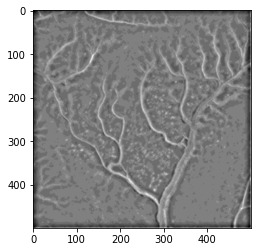

In [20]:
#obtengo alfa imagen discretizada en C clases de equivalencia
AlfaImagenC=np.zeros((ancho,alto))
for x in range(ancho):
    for y in range(alto):
        for i in range(C):
            if AlfaImagen[x,y]>=PC[i] and AlfaImagen[x,y]<PC[i+1]:
                AlfaImagenC[x,y]=VC[i] #imagen cuantizada en C clases de equivalencia #imagen cuantizada en C clases de equivalencia
plt.imshow(AlfaImagenC,'gray')
plt.show()  


In [16]:
#Defino una funcion que parte una matrix en bloques iguales
def split(Arreglo, nrows, ncols):
    r, h = Arreglo.shape
    return (Arreglo.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols))

In [17]:
L=np.array([2,4,5,10,20,25]) #tamaño de las cajas para hacer el covering de la imagen para impletmentar  box counting (cubren totalmente una imagen de 500x500)

Nalfa=np.zeros((len(VC),len(L))) # Arreglo N_alfas (cantidad de celdas caracterizadas por un alfa_i)

f_alfa=np.zeros(C) #Arreglo a utilizar para 


#obtengo los f alfas (box counting)
for j in range(C):
    for i in range(len(L)):
        Bloques=split(AlfaImagenC,L[i],L[i])
        r,s,p=Bloques.shape
#        print(Bloques.shape)
        contador=0
        for CantBloques in range(r):
            if len(np.where(Bloques[CantBloques,:,:]==VC[j])[0])!=0:
                contador=contador+1
        
        Nalfa[j,i]=contador+0.01
    (f,o)=-np.polyfit(np.log(L),np.log(Nalfa[j,:]),1)
    f_alfa[j]=f

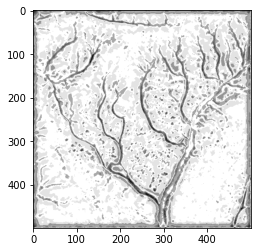

In [19]:
#genero la f alfa imagen
f_imagen=np.zeros((ancho,alto))
for x in range(ancho):
    for y in range(alto):
        for i in range(C):
            if AlfaImagenC[x,y]==VC[i]:
                f_imagen[x,y]=f_alfa[i]
            
plt.imshow(f_imagen,'gray')
plt.show()    


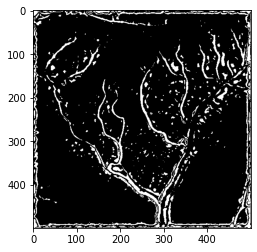

In [22]:
#puedo segmentar la imagen a traves de la f alfa imagen a traves de algun criterio que desee

umbral=threshold_otsu(f_imagen)
binary=f_imagen < umbral

plt.imshow(binary,'gray')
plt.show()    
    

#pinpin=np.ravel(AlfaImagenC)
#plt.hist(pinpin,bins=VC)
#plt.show()

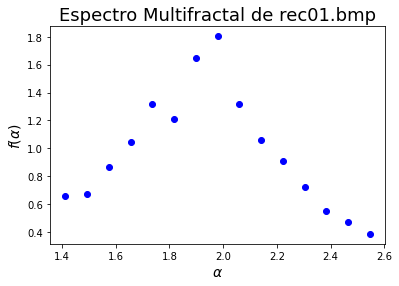

In [23]:
#grafico el espectro multifractal contra los alfa (exponentes de Hölder)
plt.plot(VC,f_alfa,'bo')
plt.ylabel(r'$f(\alpha)$',fontsize=14)
plt.xlabel(r'$ \alpha $',fontsize=14)
plt.title("Espectro Multifractal de "+imagen,fontsize=18) 
#plt.savefig('Espectro multifractal de '+imagen,format='png')
plt.show()      
